## **Settings**

- Importing all necessary libraries and modules.

In [2]:
import os, sys, random
from sys import platform
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)
from monai.utils import set_determinism
from src.helpers.utils import make_dataset, get_device
import src.modules.plotting as plot
from src.modules.training import train_test_splitting, training_model, predict_model
from src.helpers.config import get_config
from src.modules.preprocessing import get_transformations
from src.models.segresnet import SegResNet
from src.models.unet import UNet
from src.models.swinunetr import SwinUNETR

- Definition of paths.

In [3]:
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
preds_path = os.path.join(_base_path, _config.get('PRED_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
if platform == 'win32':
	saved_path = saved_path.replace('/', '\\')
	reports_path = reports_path.replace('/', '\\')
	preds_path = preds_path.replace('/', '\\')
	logs_path = logs_path.replace('/', '\\')

- Ensure reproducibility by setting a seed.

In [4]:
set_determinism(seed=3)
random.seed(3)

- Download of the dataset and splitting in **training**, **evalulation** and **testing** sets.

**NOTES**:

1. The download will start if data are not already present in `data` folder. A valid Synapse authentication token is required in `.env` file.

2. The splitting is carried out on subjects and not on sessions to avoid data leakage problem.

In [5]:
data_path = make_dataset(dataset='glioma', verbose=False)
train_data, eval_data, test_data = train_test_splitting(data_path, reports_path=reports_path, load_from_file=True)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            724 (64.0 %)        182 (16.0 %)        227 (20.0 %)        

sessions            800 (63.95 %)       202 (16.15 %)       249 (19.9 %)        



- Setting segmentation's models. Three models have been considered: **SegResNet**, **UNet** and **SwinUNETR**.

In [6]:
_models = {
	'SegResNet': SegResNet(in_channels = 4, out_channels = 3),
	'UNet': UNet(in_channels = 4, out_channels = 3),
	'SwinUNETR': SwinUNETR(in_channels = 4, out_channels = 3)
}
model = _models['SegResNet']

- Definition of images preprocessing and postprocessing pipelines.

**NOTES**:

1. Only for training set random distortions such as splittings or rotations are applied.

In [7]:
(
	train_transform,
	eval_transform,
	post_test_transform,
	post_transform
) = get_transformations(roi_size=(128, 128, 128) if model.name == 'SwinUNETR' else (224, 224, 144))

- Graph of models input and output after preprocessing. The shape is also printed.

**NOTES**:

1. The input is a 4D image, the first size corresponding to the four MRI channels. The output is also a 4D image where the first size corresponds to the three BraTS-2023 classes (ET, TC, WT).

2. The first row is a view of a sample taken from different axes. The second row shows all MRI-channels sliced on Z-axis and the third shows the relative classes cutted on the same axis.

Input image shape: torch.Size([4, 224, 224, 144])
Input label shape: torch.Size([3, 224, 224, 144])


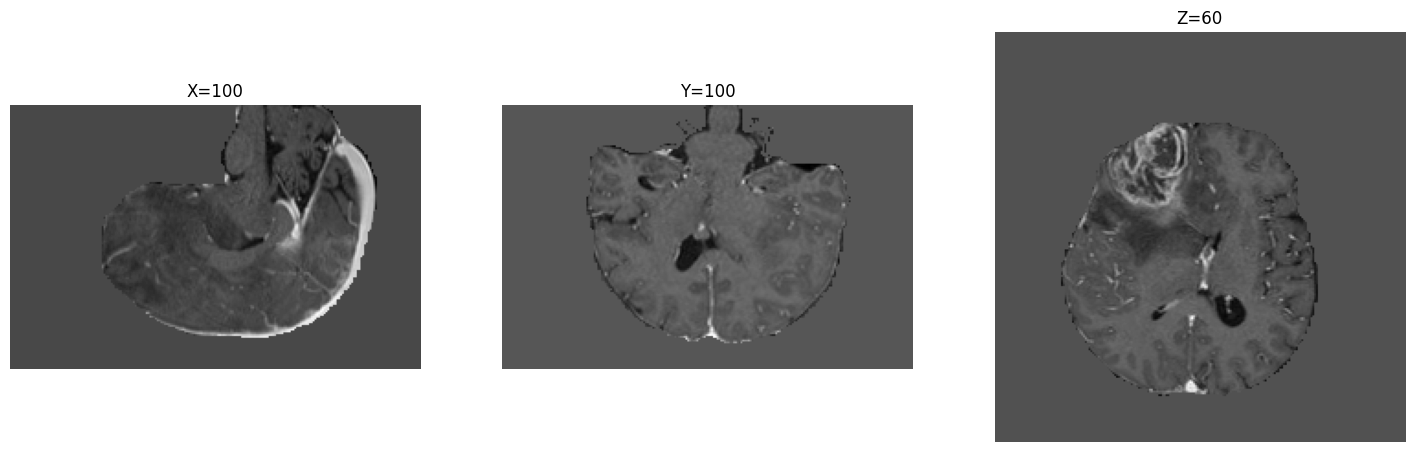

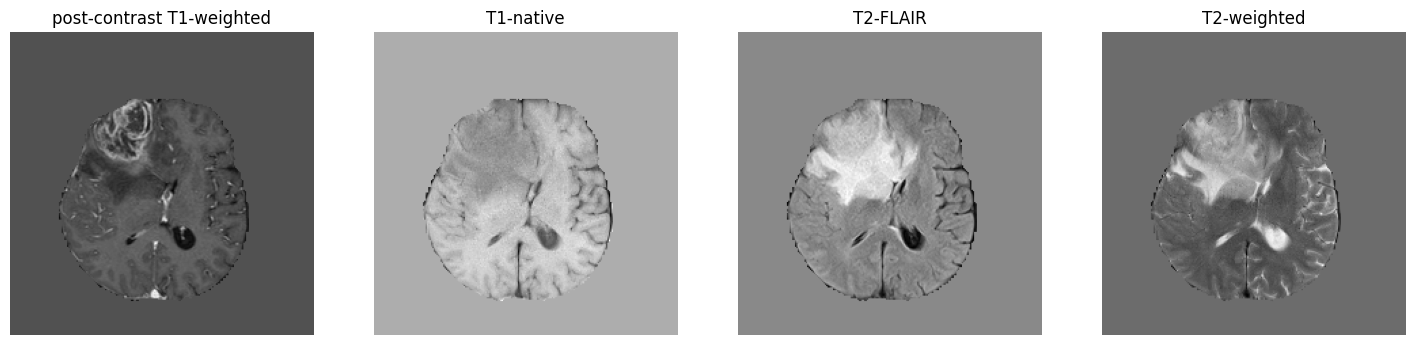

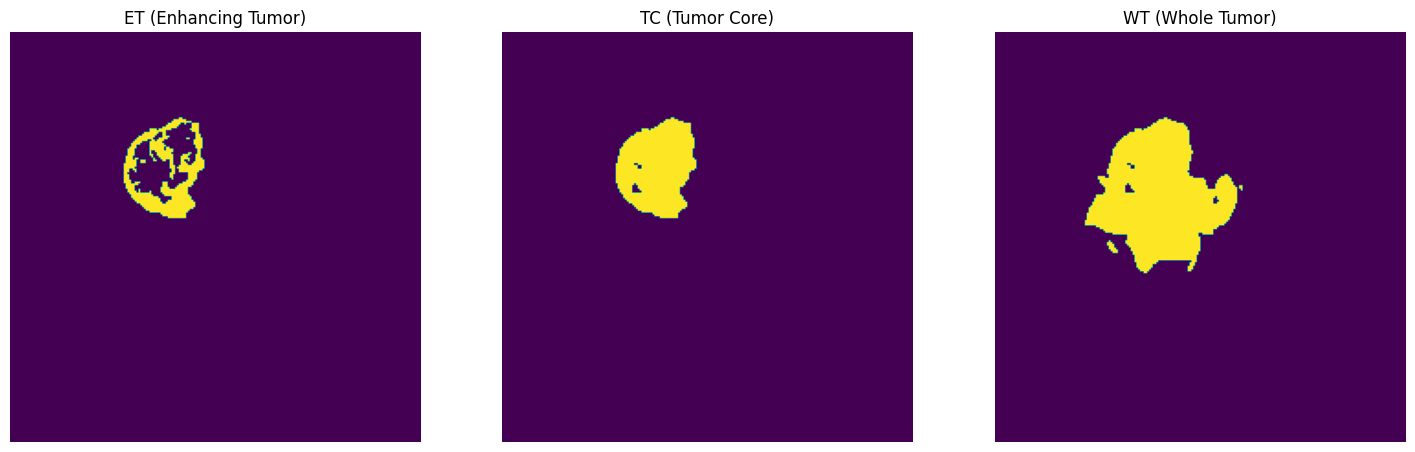

In [8]:
trans = train_transform(train_data[1])
print(f"Input image shape: {trans['image'].shape}")
print(f"Input label shape: {trans['label'].shape}")
plot.input_output(trans)

## **Training**

- Definition of the training function.

In [7]:
## NOTE: uncomment to execute the training phase.

# train_metrics = training_model(
# 	model = model,
# 	data = [train_data, eval_data],
# 	transforms = [train_transform, eval_transform, post_transform],
# 	epochs = 10,
# 	device = get_device(),
# 	paths = [saved_path, reports_path, logs_path],
#   num_workers=0,
#	verbose = True
# )

- Plot of the losses (to the left) and the scores (to the right) during the execution of the training phase for each model.

**NOTES**:

1. The total number of epochs differs for each model due to the application of early stopping technique.

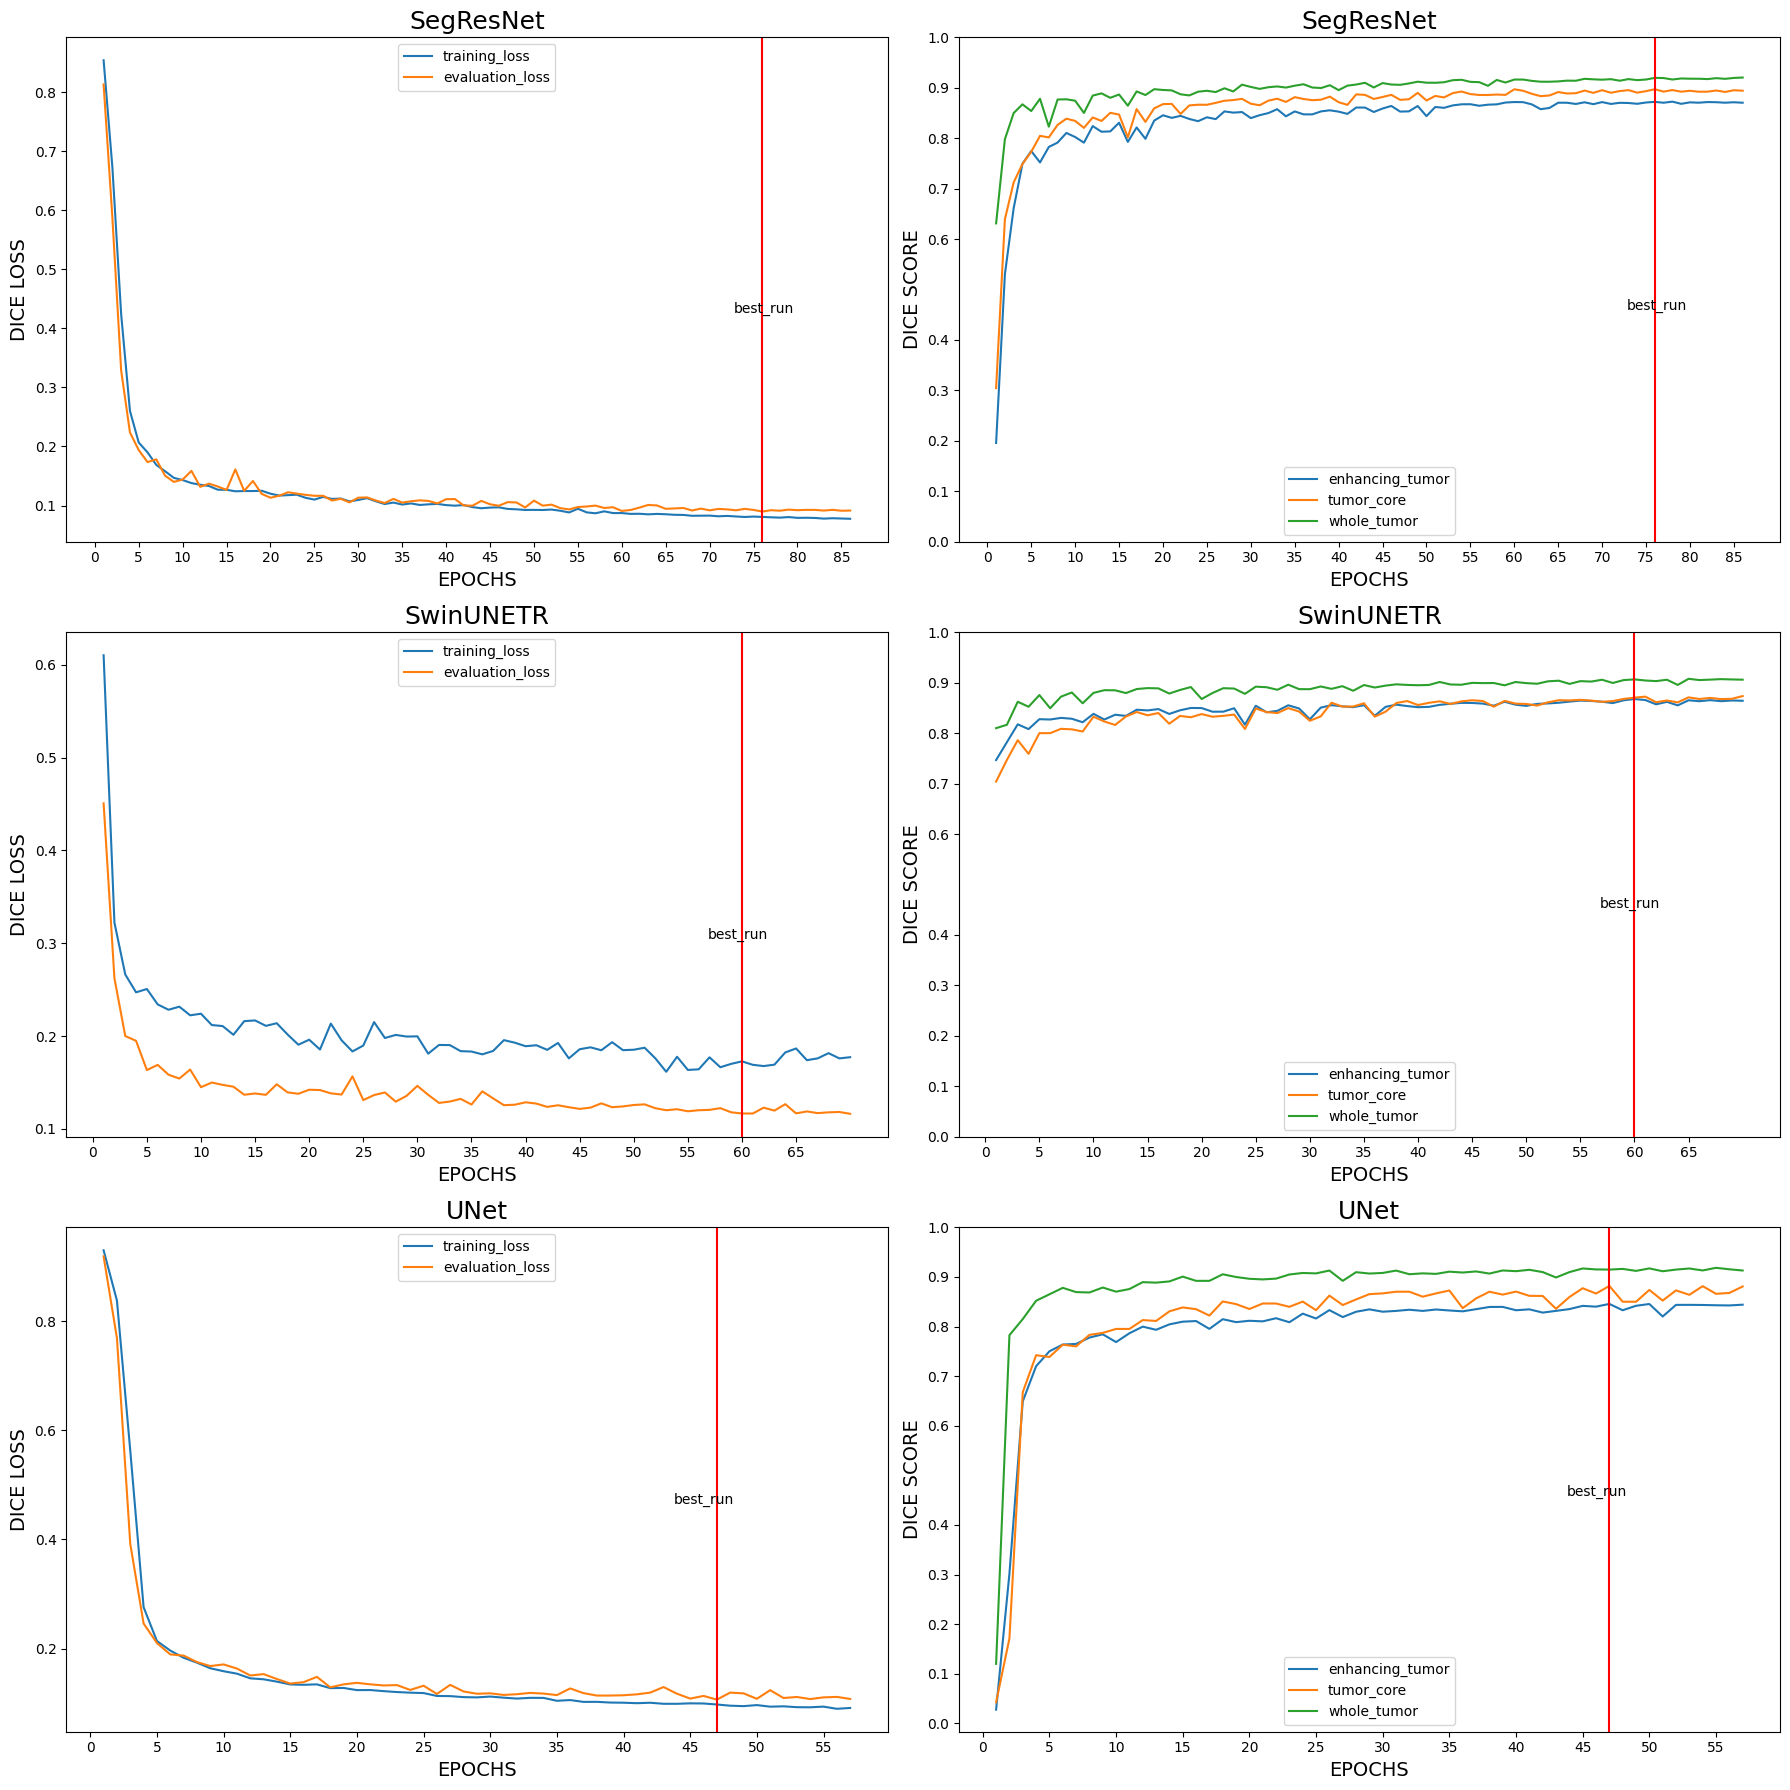

In [9]:
plot.training_values(reports_path)

## **Testing**

- Definition of testing function.

In [9]:
## NOTE: uncomment to execute the prediction on the testing set.

# test_metrics = predict_model(
# 	model = model,
# 	data = test_data,
# 	transforms = [eval_transform, post_test_transform],
# 	device = get_device(),
# 	paths = [saved_path, reports_path, preds_path, logs_path],
#   num_workers=0,
#	verbose=True
# )

- Graph of an input image, output classes and the prediction according to one of the three models passed as argument.

**NOTES**:

1. The example is randomly choose from those saved in `predictions` folder during the execution of the previously mentioned prediction function.

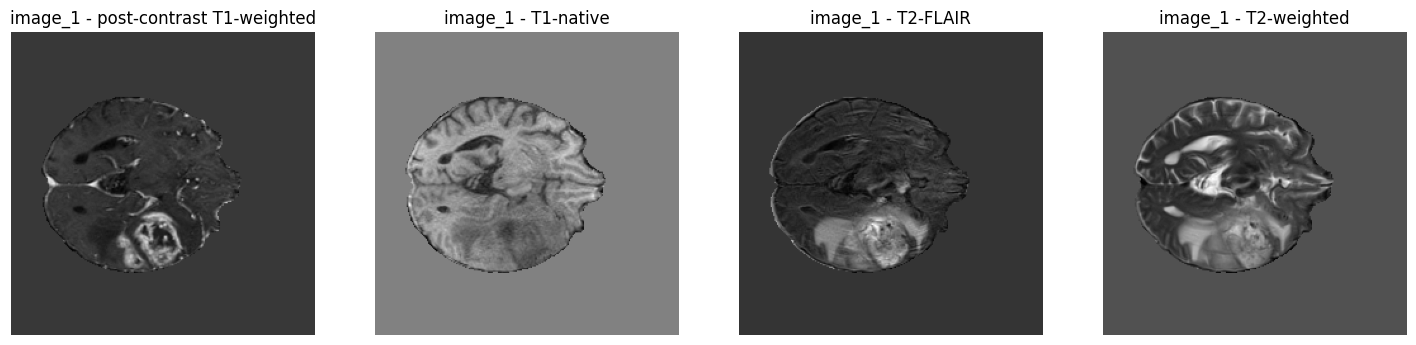

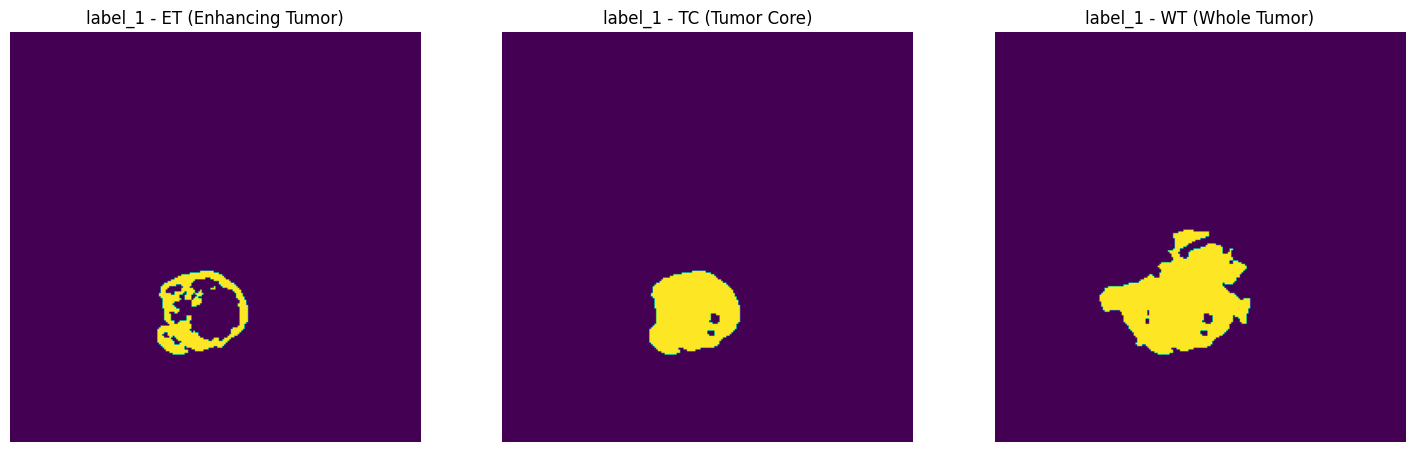

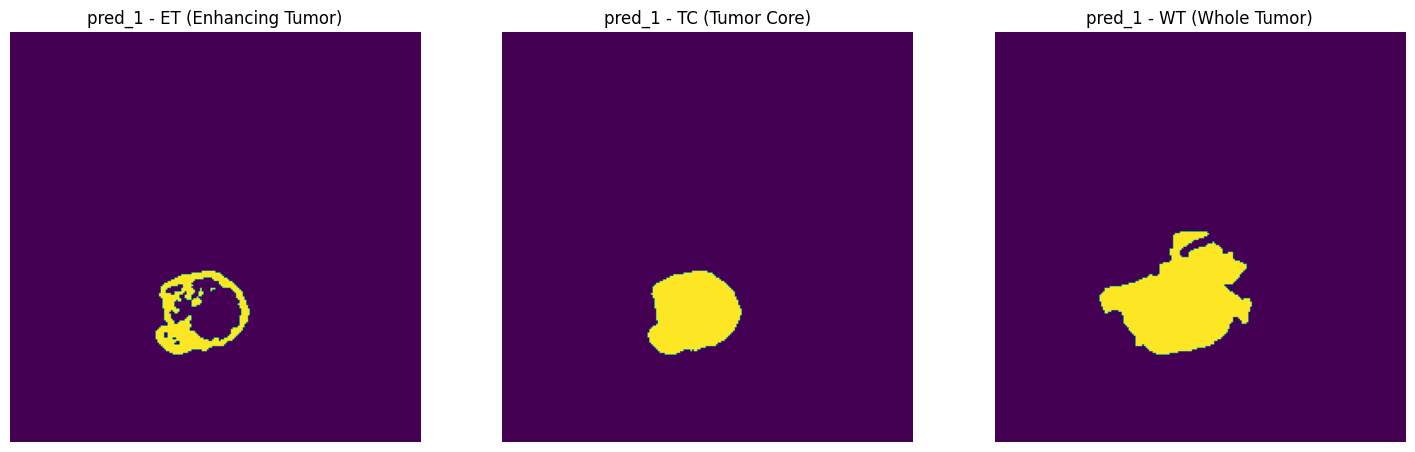

In [11]:
plot.prediction('SegResNet', preds_path)

- Print of final results.

**NOTES**:

1. According to BraTS-2023 challenge two metrics have been considered, the **dice score** and the **Hausdorff score** with 95% percentile.

In [12]:
plot.results(reports_path)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    DICE_ET        DICE_TC        DICE_WT        DICE_AVG       

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
SegResNet           0.8840         0.9112         0.9281         0.9078         
UNet                0.8483         0.8762         0.9134         0.8793         
SwinUNETR           0.8643         0.8917         0.9136         0.8899         
> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    HAUSDORFF_ET   HAUSDORFF_TC   HAUSDORFF_WT   HAUSDORFF_AVG  

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
SegResNet           3.6862         4.3484         4.9882         4.3410         
UNet                4.3396         5.7030         8.9595         6.3340         
SwinUNETR           5.2835         6.5476         8.5917         6.8076         
> > > > > > > > > > > > 